# Implementation of the Momentum Strategy

### Based on *Momentum has its moments* by Pedro Barroso and Pedro Santa-Clara (http://docentes.fe.unl.pt/~psc/MomentumMoments.pdf)

Import the necessary libraries:

In [40]:
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
import numpy as np
import alphalens
import alphalens.performance as perf 
import alphalens.utils as utils

## Make Pipeline

In [33]:
def make_pipeline():
    """
    A function to create our dynamic stock selector (pipeline). Documentation on
    pipeline can be found here: https://www.quantopian.com/help#pipeline-title
    """
    pipe = Pipeline()
    
    # Base universe set to Q1500US.
    base_universe = Q1500US()
    
    # Get returns of base universe stocks starting from 12 months ago (252 trading days ago).
    returns_12m = Returns(window_length=252, mask=base_universe)
    
    # Get returns of base universe stocks starting from 2 months ago (42 trading days ago).
    returns_2m = Returns(window_length=42, mask=base_universe)
    
    # Get returns of base universe stocks starting from 12 months and ending 2 months ago.
    returns_diff = returns_12m - returns_2m
    
    pipe.add(returns_diff, 'Momentum')
    
    # Divide those returns into deciles.
    returns_diff_decile = returns_diff.deciles()
    
    # Filter to select securities to long
    longs = (returns_diff_decile.eq(9))
    
    pipe.add(longs, 'longs')
    
    # Filter to select securities to short
    shorts = (returns_diff_decile.eq(0))
    
    pipe.add(shorts, 'shorts')
    
    # Filter for all securities that we want to trade
    securities_to_trade = (longs | shorts)
     
    pipe.set_screen(securities_to_trade)
    
    return pipe

In [34]:
results = run_pipeline(make_pipeline(), start_date='2016-08-18', end_date='2017-08-18')

In [38]:
results.head()

Momentum  longs shorts
2016-08-18 00:00:00+00:00 Equity(76 [TAP])    0.387585   True  False
                          Equity(301 [ALKS]) -0.395013  False   True
                          Equity(337 [AMAT])  0.531365   True  False
                          Equity(351 [AMD])   2.403615   True  False
                          Equity(523 [AAN])  -0.453190  False   True

## Test in Alphalens
Now that we have built our Momentum Factor and run it through a Pipeline, let's analyze its performance in Alphalens to see how good of an alpha signal it has generated over time:

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-2.363636,-0.139909,-0.470529,0.182071,14496,20.140047
2,-0.595695,-0.034522,-0.257224,0.087441,14331,19.910804
3,-0.452221,1.085279,0.184051,0.394421,14378,19.976103
4,0.330180,1.477789,0.688825,0.189679,14331,19.910804
5,0.452374,18.906747,1.575800,1.560035,14440,20.062243


Returns Analysis


,1,5,10
Ann. alpha,-0.015,-0.010,-0.006
beta,0.019,-0.117,-0.146
Mean Period Wise Return Top Quantile (bps),1.886,1.093,1.260
Mean Period Wise Return Bottom Quantile (bps),3.688,8.778,12.344
Mean Period Wise Spread (bps),-1.894,-1.586,-1.097


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/pl

Information Analysis


,1,5,10
IC Mean,0.014,0.007,-0.001
IC Std.,0.190,0.181,0.154
t-stat(IC),1.161,0.639,-0.096
p-value(IC),0.247,0.523,0.924
IC Skew,-0.316,-0.104,0.178
IC Kurtosis,-0.530,-0.361,-0.394
Ann. IR,1.182,0.651,-0.098


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.081,0.194,0.288
Quantile 2 Mean Turnover,0.206,0.433,0.558
Quantile 3 Mean Turnover,0.445,0.706,0.798
Quantile 4 Mean Turnover,0.174,0.373,0.492
Quantile 5 Mean Turnover,0.064,0.155,0.226


,1,5,10
Mean Factor Rank Autocorrelation,0.99,0.966,0.946


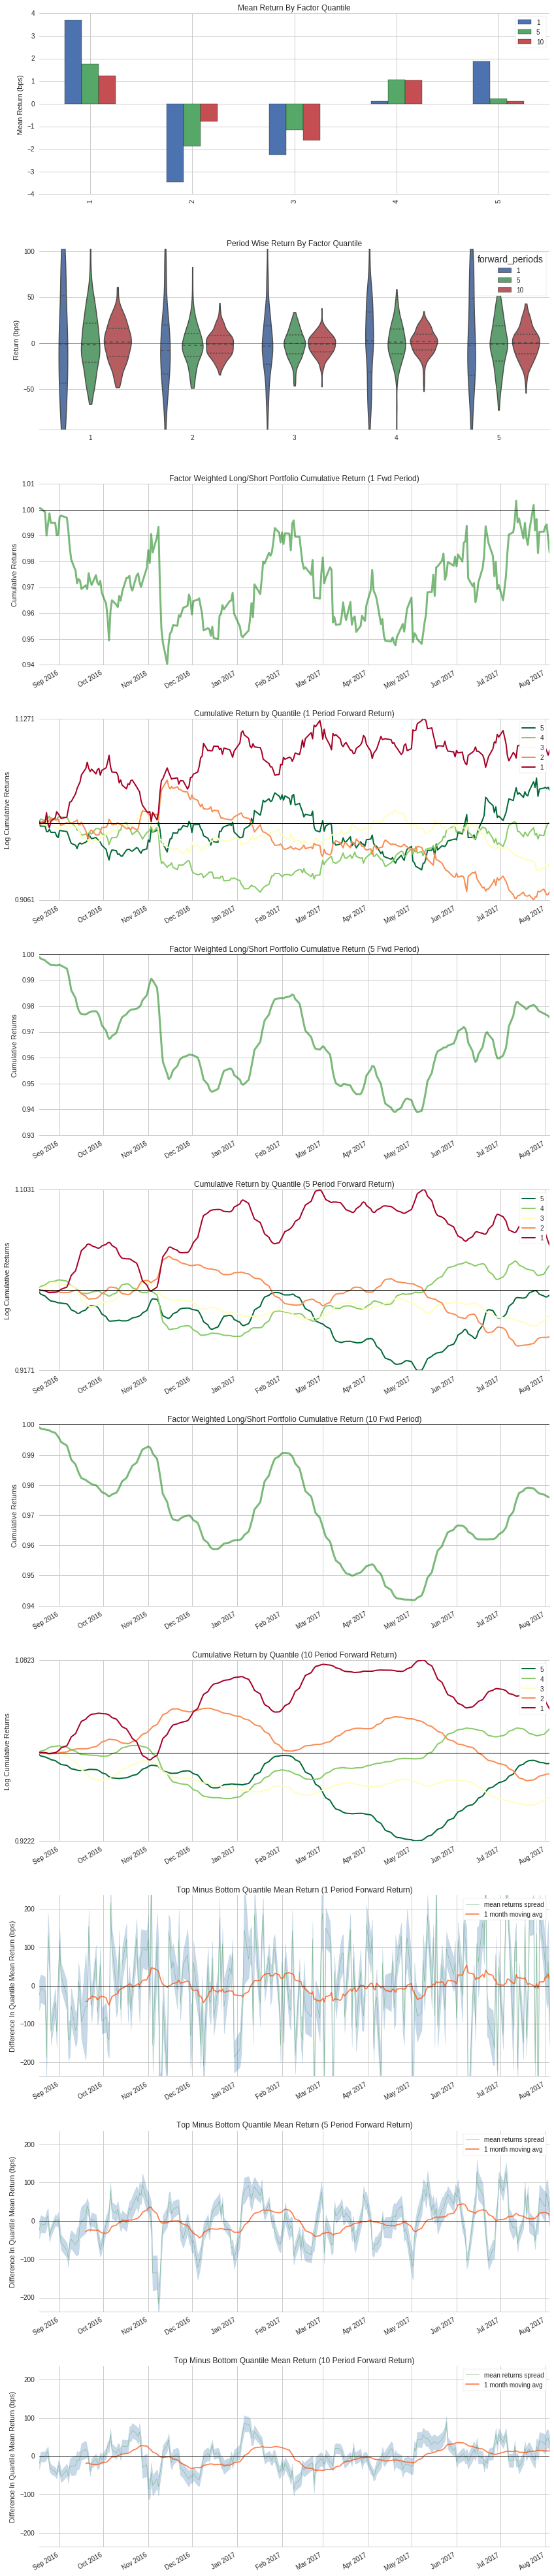

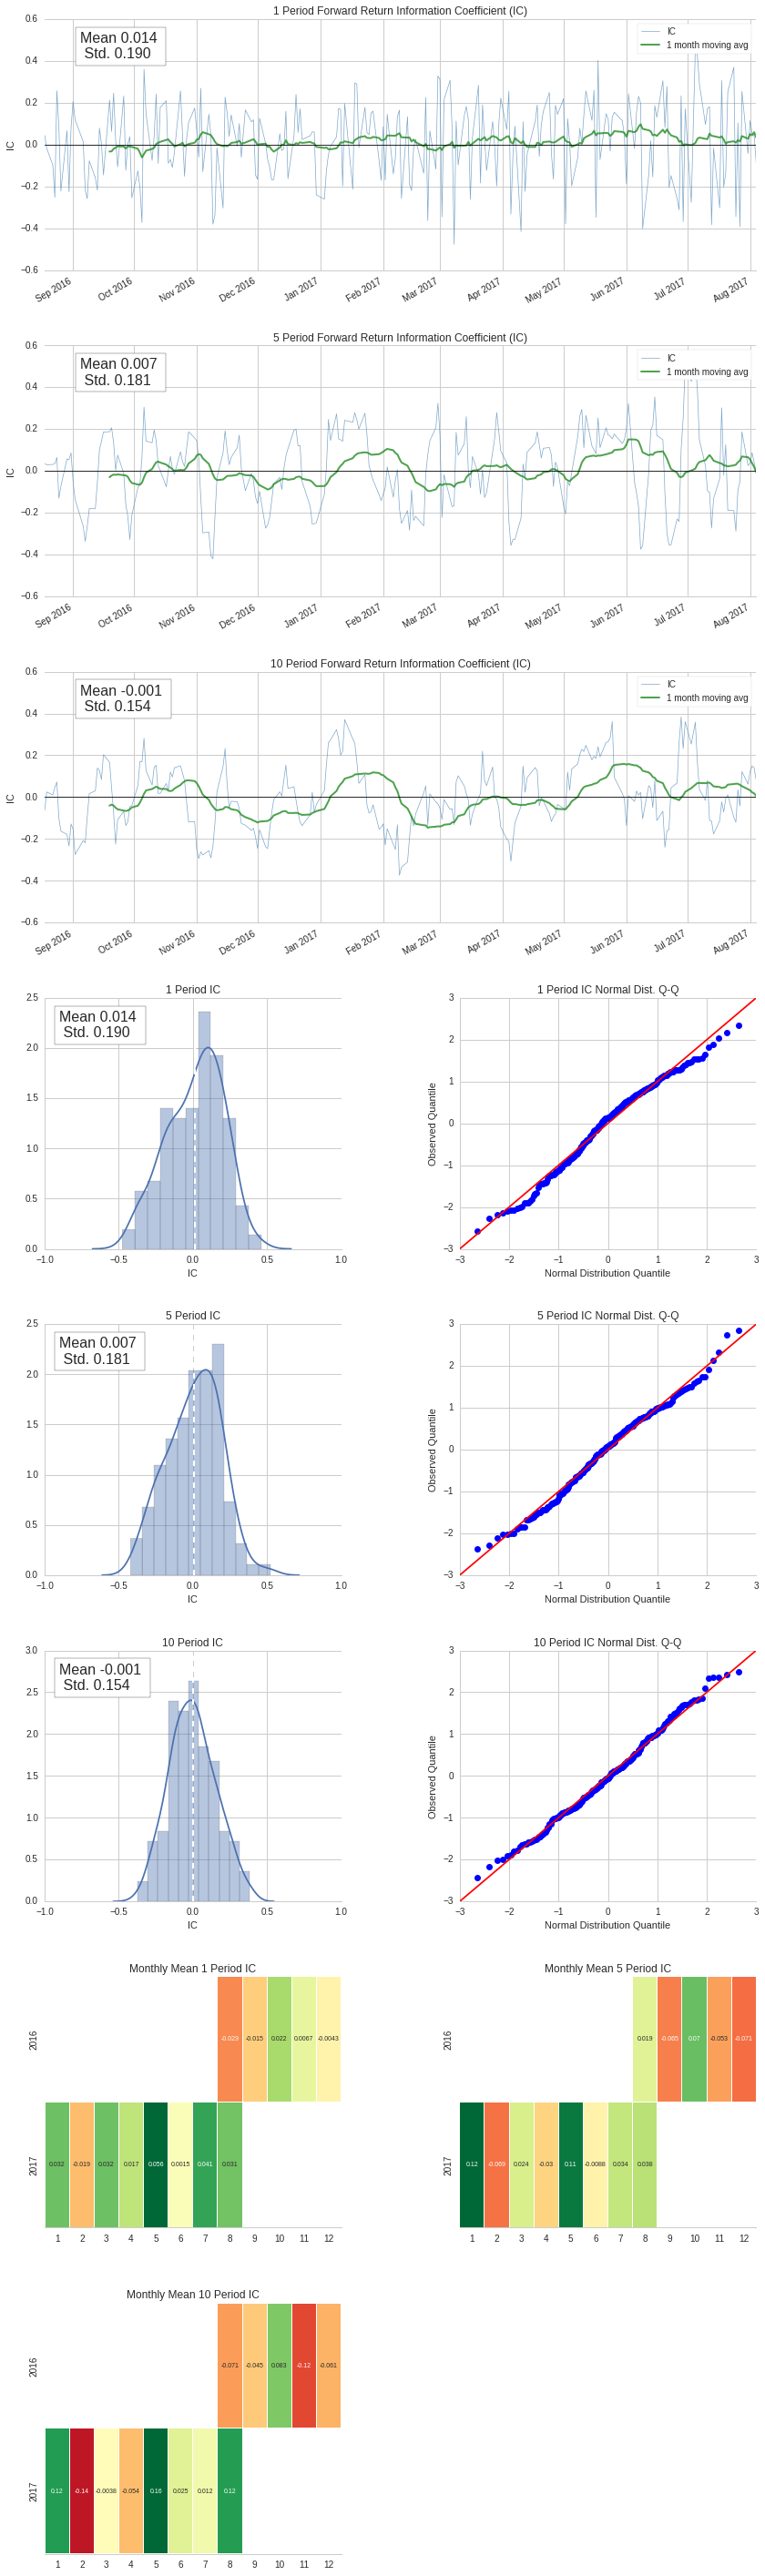

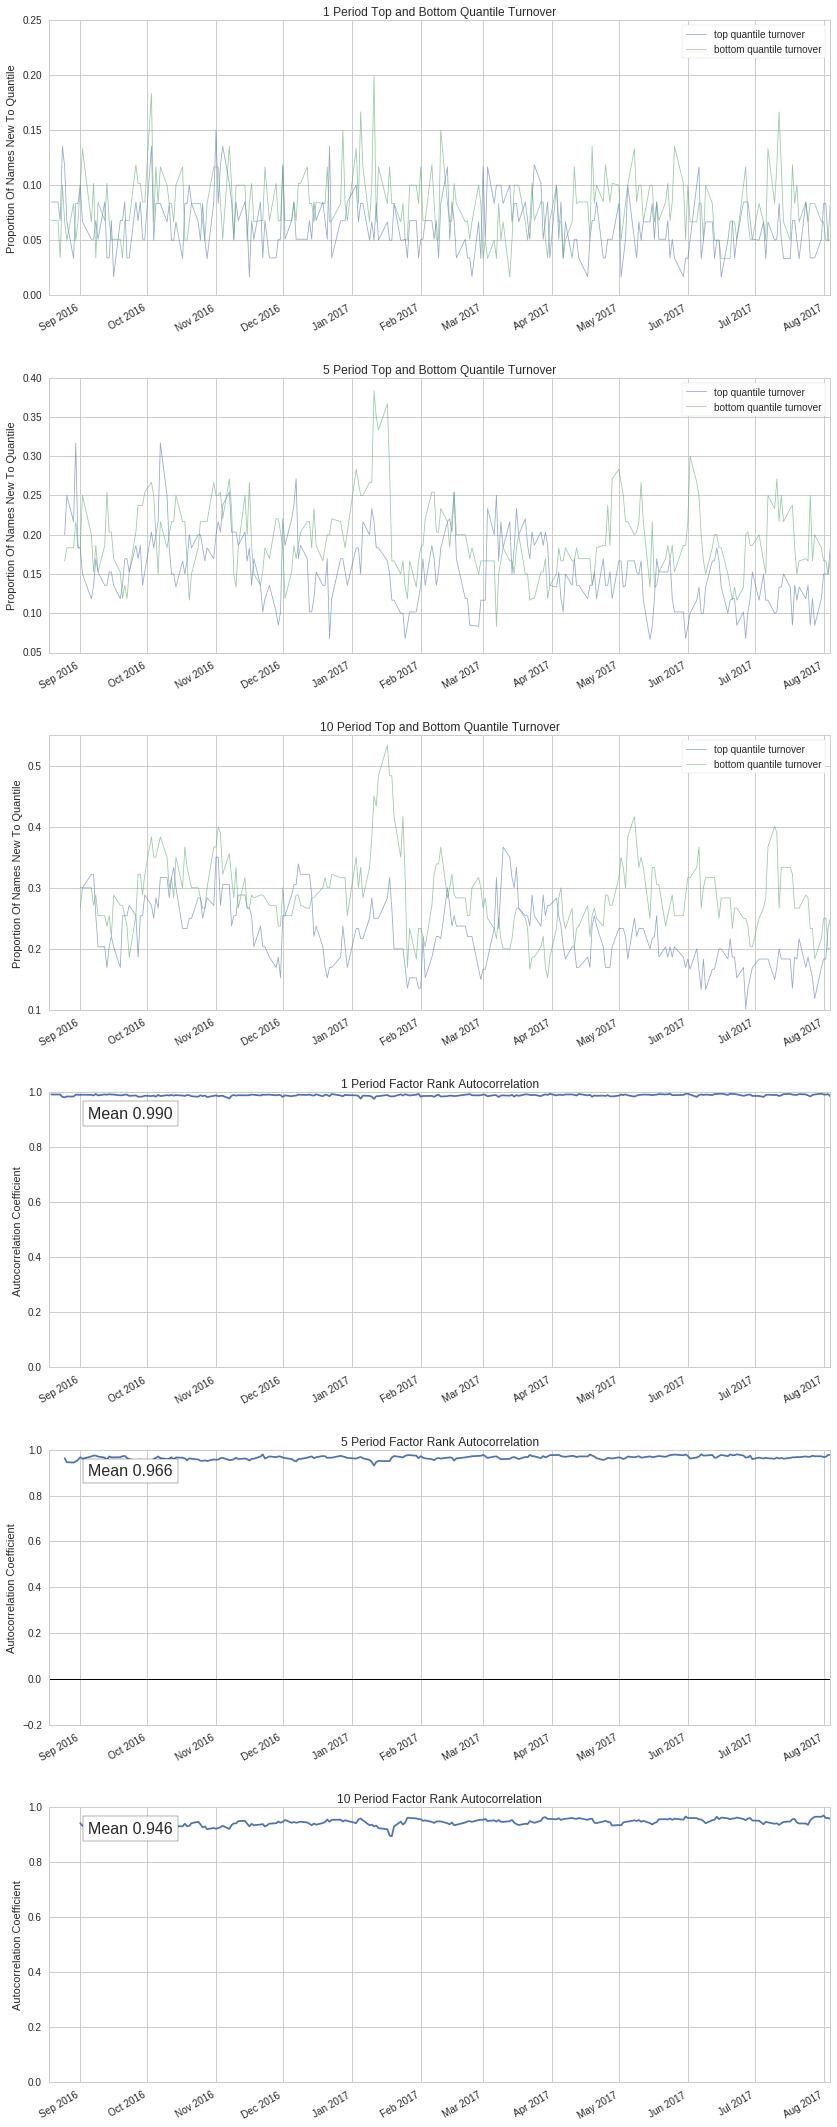

In [41]:
assets = results.index.levels[1].unique()  
pricing = get_pricing(assets, '2016-08-18', '2017-08-18', fields='open_price')

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(results['Momentum'],
                                                                     pricing,
                                                                     quantiles=5,
                                                                     periods=(1,5,10))

alphalens.tears.create_full_tear_sheet(factor_data)

## Conclusion
A better performance of the Momentum Factor than the above can be achieved by scaling the leverage of our portfolio (the maximum leverage allowed by Quantopian is 1.1) at any given point in time by the ratio of:
- the annualized daily volatility of daily market momentum for the past 6 months
                                    to
- the annual target volatility of 12%.

The following function can be used in the algorithm implementation of the Momentum Strategy to compute daily market momentum for the previous six months:

In [58]:
def my_compute_momentum(context, data):
    """
    Compute daily momentum (Winners Minus Losers) for the past six months (125 trading days).
    """
    WML_cumulative = []
    
    num_days = 125
    
    for i in range(1, num_days+1):
        winner_prices = data.history(context.longs, "price", i+1, "1d")
    
        winner_returns = winner_prices.pct_change().dropna().values
    
        loser_prices = data.history(context.shorts, "price", i+1, "1d")
    
        loser_returns = loser_prices.pct_change().dropna().values
    
        WML_current = winner_returns.mean() - loser_returns.mean()
    
        WML_cumulative.append(WML_current)
        
    return WML_cumulative